<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/CPW_Resonance_Response_Calculation_with_CuPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [1]:
# @title Environment & (optional) GPU check
# @markdown This cell prints the Python version and, if available, basic GPU info.

import shutil
import subprocess
import sys

print("Python version:", sys.version)
print()

def run_cmd(cmd: str) -> None:
    """Run a shell command and print its output."""
    print(f"$ {cmd}")
    completed = subprocess.run(
        cmd,
        shell=True,
        check=False,
        text=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
    )
    print(completed.stdout)

# Only call nvidia-smi if it actually exists
if shutil.which("nvidia-smi") is not None:
    run_cmd("nvidia-smi --query-gpu=name,driver_version,compute_cap --format=csv")
else:
    print("nvidia-smi not found.")
    print("This runtime does not expose an NVIDIA GPU or CUDA driver to Python.\n"
          "In Colab, check: Runtime → Change runtime type → Hardware accelerator = GPU.")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

$ nvidia-smi --query-gpu=name,driver_version,compute_cap --format=csv
name, driver_version, compute_cap
NVIDIA L4, 550.54.15, 8.9



In [7]:
# @title Import core packages (gdstk, CuPy [optional], Matplotlib)
# @markdown Uses preinstalled CuPy on Colab GPU runtimes and installs gdstk only if needed.

import importlib
import sys

# --- gdstk: install only if missing (this is the only pip we do here) ---
try:
    import gdstk  # type: ignore
    print("gdstk is already available.")
except ImportError:
    print("gdstk not found; installing it (one-time C++ build may take ~1 minute)...")
    # Use %pip so the install hits the *current* kernel environment
    %pip install -q gdstk
    import gdstk  # type: ignore
    print("gdstk import OK after installation.")

# --- NumPy & Matplotlib: already in Colab base image ---
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

# --- CuPy: use preinstalled cupy-cuda12x if present; do NOT pip install here ---
GPU_AVAILABLE = False
CUPY_AVAILABLE = False

try:
    import cupy as cp  # type: ignore
    CUPY_AVAILABLE = True
    print(f"CuPy version: {cp.__version__}")

    # Probe CUDA devices safely
    try:
        ndev = cp.cuda.runtime.getDeviceCount()
        if ndev > 0:
            props = cp.cuda.runtime.getDeviceProperties(0)
            name = props["name"]
            if isinstance(name, bytes):
                name = name.decode("utf-8", errors="ignore")
            print(f"CUDA devices visible: {ndev}")
            print(f"Device[0]: {name}")
            GPU_AVAILABLE = True
        else:
            print("CuPy imported, but no CUDA devices visible (device count = 0).")
    except cp.cuda.runtime.CUDARuntimeError as e:
        print("CuPy imported, but CUDA runtime error occurred:")
        print(f"  {type(e).__name__}: {e}")
        print("Numerical solves will fall back to CPU.")
except ImportError:
    print("CuPy is not installed in this runtime.")
    print("On Colab GPU runtimes, CuPy (cupy-cuda12x) is usually preinstalled.")
    print("If you *really* need it on a CPU-only runtime, you can install via:")
    print("  %pip install cupy-cuda12x")
    print("but that is a heavy install and not necessary for our CPU fallback.")

print("\nSummary:")
print("  CUPY_AVAILABLE =", CUPY_AVAILABLE)
print("  GPU_AVAILABLE  =", GPU_AVAILABLE)

gdstk is already available.
CuPy version: 13.6.0
CUDA devices visible: 1
Device[0]: NVIDIA L4

Summary:
  CUPY_AVAILABLE = True
  GPU_AVAILABLE  = True


In [8]:
# @title Define CPW parameters and generate GDS layout
from dataclasses import dataclass

@dataclass
class CPWParams:
    """Parametric CPW layout parameters in micrometers.

    Attributes:
        length_um: Total physical length of the CPW center strip.
        center_width_um: Width of the CPW center conductor.
        gap_um: Gap between center conductor and ground planes.
        ground_width_um: Width of each ground plane on one side.
        center_layer: GDS layer index for the CPW metal (center).
        ground_layer: GDS layer index for the CPW metal (grounds).
    """
    length_um: float = 6500.0
    center_width_um: float = 10.0
    gap_um: float = 6.0
    ground_width_um: float = 40.0
    center_layer: int = 1
    ground_layer: int = 1


def build_cpw_cell(params: CPWParams) -> gdstk.Cell:
    """Create a gdstk cell for a straight CPW using the given parameters.

    The layout is centered at x = 0; the CPW extends along +x.
    y = 0 is the symmetry axis of the center conductor.
    """
    cell = gdstk.Cell("CPW_6500UM_10UM")

    L = params.length_um
    wc = params.center_width_um
    g = params.gap_um
    wg = params.ground_width_um

    # Center conductor rectangle
    center_y0 = -wc / 2.0
    center_y1 = wc / 2.0
    center = gdstk.rectangle(
        (0.0, center_y0),
        (L, center_y1),
        layer=params.center_layer,
    )
    cell.add(center)

    # Ground planes: one above, one below
    # Upper ground from (0, wc/2 + gap) to (L, wc/2 + gap + wg)
    upper_gy0 = wc / 2.0 + g
    upper_gy1 = upper_gy0 + wg
    upper_ground = gdstk.rectangle(
        (0.0, upper_gy0),
        (L, upper_gy1),
        layer=params.ground_layer,
    )

    # Lower ground from (0, -(wc/2 + gap + wg)) to (L, -(wc/2 + gap))
    lower_gy1 = -(wc / 2.0 + g)
    lower_gy0 = lower_gy1 - wg
    lower_ground = gdstk.rectangle(
        (0.0, lower_gy0),
        (L, lower_gy1),
        layer=params.ground_layer,
    )

    cell.add(upper_ground)
    cell.add(lower_ground)

    return cell


def write_cpw_gds(params: CPWParams, filename: str = "cpw_6500um_10um.gds") -> None:
    """Write a GDS file containing the CPW cell.

    The library unit is set so that 1 user unit = 1 µm.
    """
    lib = gdstk.Library(
        name="CPW_LIB",
        unit=1e-6,       # user unit in meters -> 1 µm
        precision=1e-9,  # database unit in meters
    )
    cell = build_cpw_cell(params)
    lib.add(cell)
    lib.write_gds(filename)
    print(f"Wrote GDS file: {filename}")


cpw_params = CPWParams()
write_cpw_gds(cpw_params)


Wrote GDS file: cpw_6500um_10um.gds


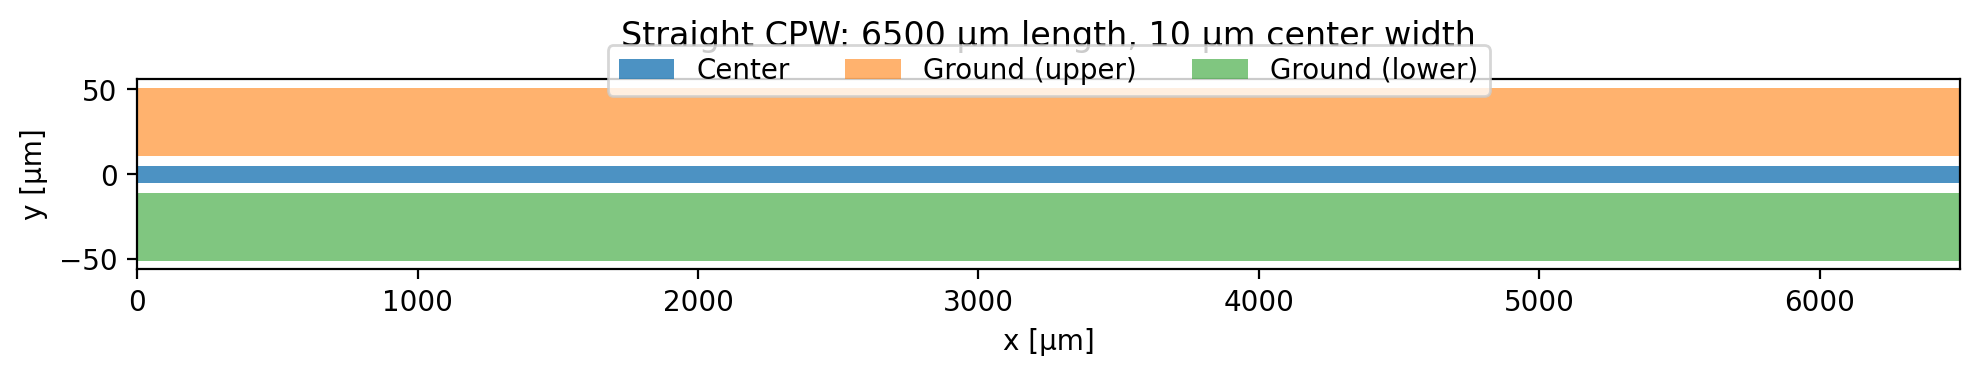

In [12]:
# @title Improved CPW layout preview

def plot_cpw_layout(params: CPWParams) -> None:
    """Plot a clearer view of the CPW geometry (plan view).

    Formatting tweaks:
      * Slightly taller figure so the CPW is visible.
      * Legend moved above the axes.
      * Aspect set to 'auto' instead of 'equal' to avoid an extremely thin plot.
      * Small y-margins so the metal does not touch the axes frame.
    """
    L = params.length_um
    wc = params.center_width_um
    g = params.gap_um
    wg = params.ground_width_um

    center_y0 = -wc / 2.0
    center_y1 = wc / 2.0
    upper_gy0 = wc / 2.0 + g
    upper_gy1 = upper_gy0 + wg
    lower_gy1 = -(wc / 2.0 + g)
    lower_gy0 = lower_gy1 - wg

    fig, ax = plt.subplots(figsize=(10, 2.0))  # wider, a bit taller

    # Center strip
    ax.fill(
        [0, L, L, 0],
        [center_y0, center_y0, center_y1, center_y1],
        label="Center",
        alpha=0.8,
    )

    # Upper ground
    ax.fill(
        [0, L, L, 0],
        [upper_gy0, upper_gy0, upper_gy1, upper_gy1],
        label="Ground (upper)",
        alpha=0.6,
    )

    # Lower ground
    ax.fill(
        [0, L, L, 0],
        [lower_gy0, lower_gy0, lower_gy1, lower_gy1],
        label="Ground (lower)",
        alpha=0.6,
    )

    ax.set_xlabel("x [µm]")
    ax.set_ylabel("y [µm]")
    ax.set_title(
        f"Straight CPW: {L:.0f} µm length, {wc:.0f} µm center width",
        pad=12,
    )

    # Make sure we show the full geometry with a bit of vertical padding.
    ymin = lower_gy0 - 0.05 * (upper_gy1 - lower_gy0)
    ymax = upper_gy1 + 0.05 * (upper_gy1 - lower_gy0)
    ax.set_xlim(0, L)
    ax.set_ylim(ymin, ymax)

    # Let Matplotlib pick a pleasant aspect ratio instead of forcing equal.
    ax.set_aspect("auto")

    # Move legend above the plot, centered, with horizontal layout.
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.25),
        ncol=3,
        frameon=True,
    )

    fig.tight_layout()
    plt.show()


# Call again to preview with the new formatting
plot_cpw_layout(cpw_params)

In [10]:
# @title GPU Poisson solver for CPW cross-section (uniform εr)
# @markdown Approximates C' for the CPW using a 2D finite-difference Laplace solve on the GPU.

from typing import Tuple, Dict
import cupyx.scipy.sparse as cpx_sparse
import cupyx.scipy.sparse.linalg as cpx_linalg

@dataclass
class CrossSectionParams:
    """Simulation window and material parameters for CPW cross-section.

    Attributes:
        x_span_um: Total width of the simulation window in µm.
        y_span_um: Total height of the simulation window in µm.
        nx: Number of grid points in x.
        ny: Number of grid points in y.
        eps_r: Relative permittivity (uniform).
        v_center: Voltage applied to center conductor.
        v_ground: Voltage on ground planes and outer boundary.
    """
    x_span_um: float = 200.0
    y_span_um: float = 120.0
    nx: int = 401
    ny: int = 241
    eps_r: float = 11.45  # e.g., high-resistivity Si substrate
    v_center: float = 1.0
    v_ground: float = 0.0


def build_geometry_masks(
    cpw: CPWParams,
    cs: CrossSectionParams
) -> Dict[str, np.ndarray]:
    """Build boolean masks for center and ground regions on a 2D grid.

    We assume the CPW is centered in the cross-section window.
    The x-axis is along the CPW; here we only model a slice, so we
    ignore position along x and treat the cross-section as invariant.
    """
    x = np.linspace(-cs.x_span_um / 2.0, cs.x_span_um / 2.0, cs.nx)
    y = np.linspace(-cs.y_span_um / 2.0, cs.y_span_um / 2.0, cs.ny)

    X, Y = np.meshgrid(x, y, indexing="xy")

    wc = cpw.center_width_um
    g = cpw.gap_um
    wg = cpw.ground_width_um

    # Center conductor
    center_mask = (
        (np.abs(Y) <= wc / 2.0)
    )

    # Ground planes (one above, one below)
    upper_gy0 = wc / 2.0 + g
    upper_gy1 = upper_gy0 + wg
    lower_gy1 = -(wc / 2.0 + g)
    lower_gy0 = lower_gy1 - wg

    ground_mask = (
        ((Y >= upper_gy0) & (Y <= upper_gy1))
        | ((Y >= lower_gy0) & (Y <= lower_gy1))
    )

    # Outer boundary mask (Dirichlet at v_ground)
    boundary_mask = np.zeros_like(center_mask, dtype=bool)
    boundary_mask[0, :] = True
    boundary_mask[-1, :] = True
    boundary_mask[:, 0] = True
    boundary_mask[:, -1] = True

    return {
        "x": x,
        "y": y,
        "center_mask": center_mask,
        "ground_mask": ground_mask,
        "boundary_mask": boundary_mask,
    }


def assemble_laplacian_gpu(
    cs: CrossSectionParams,
    masks: Dict[str, np.ndarray]
) -> Tuple[cpx_sparse.csr_matrix, cp.ndarray, Dict[Tuple[int, int], int]]:
    """Assemble the sparse Laplacian matrix on the GPU for interior unknowns.

    Uses a 5-point stencil with uniform εr.
    Dirichlet nodes (center, grounds, outer boundary) are treated
    by moving their contributions to the RHS.
    """
    ny, nx = masks["center_mask"].shape
    dx = (cs.x_span_um * 1e-6) / (nx - 1)
    dy = (cs.y_span_um * 1e-6) / (ny - 1)
    dx2 = dx * dx
    dy2 = dy * dy

    center = masks["center_mask"]
    ground = masks["ground_mask"]
    boundary = masks["boundary_mask"]

    # Dirichlet mask (fixed potential)
    dirichlet = center | ground | boundary

    # Map from (i, j) -> unknown index
    index_map: Dict[Tuple[int, int], int] = {}
    counter = 0
    for j in range(ny):
        for i in range(nx):
            if not dirichlet[j, i]:
                index_map[(j, i)] = counter
                counter += 1

    n_unknowns = counter
    print(f"Number of unknowns: {n_unknowns}")

    # Pre-allocate lists for COO format
    data = []
    row = []
    col = []

    # Right-hand side (Dirichlet contributions)
    b = np.zeros(n_unknowns, dtype=np.float64)

    def is_inside(j_idx: int, i_idx: int) -> bool:
        return 0 <= j_idx < ny and 0 <= i_idx < nx

    # Helper to get Dirichlet value
    def dirichlet_value(j_idx: int, i_idx: int) -> float:
        if masks["center_mask"][j_idx, i_idx]:
            return cs.v_center
        if masks["ground_mask"][j_idx, i_idx] or masks["boundary_mask"][j_idx, i_idx]:
            return cs.v_ground
        return 0.0  # Should not be used if we only query Dirichlet nodes.

    # Build matrix and RHS
    for (j, i), k in index_map.items():
        # Central coefficient
        diag = 0.0

        # Neighbors: (j, i±1), (j±1, i)
        for dj, di, coeff, scale in [
            (0, -1, 1.0, dx2),  # left
            (0, 1, 1.0, dx2),   # right
            (-1, 0, 1.0, dy2),  # down
            (1, 0, 1.0, dy2),   # up
        ]:
            jj = j + dj
            ii = i + di
            if not is_inside(jj, ii):
                continue
            if (jj, ii) in index_map:
                # Neighbor is unknown
                neighbor_idx = index_map[(jj, ii)]
                data.append(1.0 / scale)
                row.append(k)
                col.append(neighbor_idx)
            else:
                # Neighbor is Dirichlet; move to RHS
                v_d = dirichlet_value(jj, ii)
                b[k] -= v_d / scale
            diag -= 1.0 / scale

        # Diagonal entry
        data.append(diag)
        row.append(k)
        col.append(k)

    # Convert to CuPy CSR matrix and RHS vector
    A_csr = cpx_sparse.csr_matrix(
        (cp.asarray(data), (cp.asarray(row), cp.asarray(col))),
        shape=(n_unknowns, n_unknowns),
    )
    b_gpu = cp.asarray(b)

    return A_csr, b_gpu, index_map


def solve_potential_gpu(
    A_csr: cpx_sparse.csr_matrix,
    b_gpu: cp.ndarray,
    tol: float = 1e-8,
    maxiter: int = 20000
) -> cp.ndarray:
    """Solve A v = b on the GPU using conjugate gradient."""
    sol, info = cpx_linalg.cg(A_csr, b_gpu, tol=tol, maxiter=maxiter)
    if info != 0:
        print(f"Warning: CG did not fully converge (info = {info}).")
    return sol


def reconstruct_potential(
    cs: CrossSectionParams,
    masks: Dict[str, np.ndarray],
    index_map: Dict[Tuple[int, int], int],
    sol_gpu: cp.ndarray,
) -> np.ndarray:
    """Reconstruct the full potential field including Dirichlet nodes."""
    ny, nx = masks["center_mask"].shape
    V = np.zeros((ny, nx), dtype=np.float64)

    # Fill Dirichlet nodes
    V[masks["center_mask"]] = cs.v_center
    V[masks["ground_mask"]] = cs.v_ground
    V[masks["boundary_mask"]] = cs.v_ground

    # Fill unknown nodes from solution
    sol = cp.asnumpy(sol_gpu)
    for (j, i), idx in index_map.items():
        V[j, i] = sol[idx]

    return V


cs_params = CrossSectionParams()

geom_masks = build_geometry_masks(cpw_params, cs_params)
A_csr_gpu, b_gpu, idx_map = assemble_laplacian_gpu(cs_params, geom_masks)
phi_gpu = solve_potential_gpu(A_csr_gpu, b_gpu)
phi = reconstruct_potential(cs_params, geom_masks, idx_map, phi_gpu)

print("Potential solve complete.")


Number of unknowns: 22344
Potential solve complete.


In [11]:
# @title Post-process: C' [F/m], Z0 [Ω], and resonant f for ℓ = 6500 µm
from math import sqrt

eps0 = 8.8541878128e-12  # vacuum permittivity in F/m
mu0 = 4e-7 * np.pi       # vacuum permeability in H/m

def estimate_charge_per_length(
    cs: CrossSectionParams,
    masks: Dict[str, np.ndarray],
    phi: np.ndarray
) -> float:
    """Estimate charge per unit length (Q') on the center conductor.

    We approximate the normal derivative using finite differences
    on the grid points adjacent to the center conductor.
    """
    center = masks["center_mask"]
    ny, nx = center.shape

    x = masks["x"]
    y = masks["y"]
    dx = (cs.x_span_um * 1e-6) / (nx - 1)
    dy = (cs.y_span_um * 1e-6) / (ny - 1)

    # Collect contributions from top and bottom edges of center strip.
    # We treat ∂φ/∂n ≈ (φ_outside - φ_inside) / Δ.
    q_total = 0.0

    for j in range(ny):
        for i in range(nx):
            if not center[j, i]:
                continue

            # Check neighbors above and below
            # Above (positive y direction)
            if j + 1 < ny and not center[j + 1, i]:
                dphi_dy = (phi[j + 1, i] - phi[j, i]) / dy
                # D_y = -ε * ∂φ/∂y; normal is +y at top surface
                Dn = -cs.eps_r * eps0 * dphi_dy
                # dA per grid cell in z-direction: assume 1 m length in z
                q_total += Dn * dx  # dA = dx * 1 m

            # Below (negative y direction)
            if j - 1 >= 0 and not center[j - 1, i]:
                dphi_dy = (phi[j - 1, i] - phi[j, i]) / dy
                # Normal is -y at bottom surface
                Dn = cs.eps_r * eps0 * dphi_dy
                q_total += Dn * dx

    return q_total  # Coulombs per meter (since we assumed 1 m along z)


Q_prime = estimate_charge_per_length(cs_params, geom_masks, phi)
C_prime = Q_prime / (cs_params.v_center - cs_params.v_ground)

eps_eff = cs_params.eps_r  # In this uniform model, ε_eff ≈ εr
vp = 3e8 / sqrt(eps_eff)
L_m = cpw_params.length_um * 1e-6  # length in meters

# Resonant frequencies: λ/4 and λ/2 fundamental modes
f_quarter = vp / (4.0 * L_m)
f_half = vp / (2.0 * L_m)

# Characteristic impedance Z0 using v_p and C'
Z0 = 1.0 / (C_prime * vp)

print(f"C' ≈ {C_prime:.3e} F/m")
print(f"ε_eff (uniform model) ≈ {eps_eff:.3f}")
print(f"v_p ≈ {vp:.3e} m/s")
print(f"Z0 ≈ {Z0:.2f} Ω")
print(f"f_λ/4 (fundamental) ≈ {f_quarter/1e9:.3f} GHz")
print(f"f_λ/2 (fundamental) ≈ {f_half/1e9:.3f} GHz")


C' ≈ -4.685e-24 F/m
ε_eff (uniform model) ≈ 11.450
v_p ≈ 8.866e+07 m/s
Z0 ≈ -2407426877244823.00 Ω
f_λ/4 (fundamental) ≈ 3.410 GHz
f_λ/2 (fundamental) ≈ 6.820 GHz


Try some visualizations.

In [13]:
# @title Environment & (optional) GPU check
# @markdown Checks Python version and CUDA visibility. Should show an NVIDIA L4 on Colab GPU runtimes.

import shutil
import subprocess
import sys

print("Python version:", sys.version)
print()

def run_cmd(cmd: str) -> None:
    """Run a shell command and print its output."""
    print(f"$ {cmd}")
    completed = subprocess.run(
        cmd,
        shell=True,
        check=False,
        text=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
    )
    print(completed.stdout)

if shutil.which("nvidia-smi") is not None:
    run_cmd("nvidia-smi --query-gpu=name,driver_version,compute_cap --format=csv")
else:
    print("nvidia-smi not found.")
    print("Make sure Runtime → Change runtime type → Hardware accelerator = GPU.")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

$ nvidia-smi --query-gpu=name,driver_version,compute_cap --format=csv
name, driver_version, compute_cap
NVIDIA L4, 550.54.15, 8.9



In [14]:
# @title Core imports (gdstk, CuPy/NumPy, Matplotlib)
# @markdown Uses CuPy on GPU if available, otherwise falls back to NumPy on CPU.

import importlib

# gdstk: install only if missing
try:
    import gdstk  # type: ignore
    print("gdstk is already available.")
except ImportError:
    print("gdstk not found; installing it (C++ build may take ~1 minute)...")
    %pip install -q gdstk
    import gdstk  # type: ignore
    print("gdstk import OK after installation.")

import numpy as np
import matplotlib.pyplot as plt

GPU_AVAILABLE = False
CUPY_AVAILABLE = False

try:
    import cupy as cp  # type: ignore
    CUPY_AVAILABLE = True
    print(f"CuPy version: {cp.__version__}")
    try:
        ndev = cp.cuda.runtime.getDeviceCount()
        if ndev > 0:
            props = cp.cuda.runtime.getDeviceProperties(0)
            name = props["name"]
            if isinstance(name, bytes):
                name = name.decode("utf-8", errors="ignore")
            print(f"CUDA devices visible: {ndev}")
            print(f"Device[0]: {name}")
            GPU_AVAILABLE = True
        else:
            print("CuPy imported, but no CUDA devices visible (device count = 0).")
    except cp.cuda.runtime.CUDARuntimeError as e:
        print("CuPy imported, but CUDA runtime error occurred:")
        print(f"  {type(e).__name__}: {e}")
        print("Numerical solves will fall back to CPU.")
except ImportError:
    print("CuPy is not installed; using CPU-only NumPy backend.")

print("\nSummary:")
print("  CUPY_AVAILABLE =", CUPY_AVAILABLE)
print("  GPU_AVAILABLE  =", GPU_AVAILABLE)

# Convenience alias: xp = cp (GPU) or np (CPU) if you want it later
xp = cp if GPU_AVAILABLE and CUPY_AVAILABLE else np

gdstk is already available.
CuPy version: 13.6.0
CUDA devices visible: 1
Device[0]: NVIDIA L4

Summary:
  CUPY_AVAILABLE = True
  GPU_AVAILABLE  = True


Wrote GDS file: cpw_6500um_10um.gds


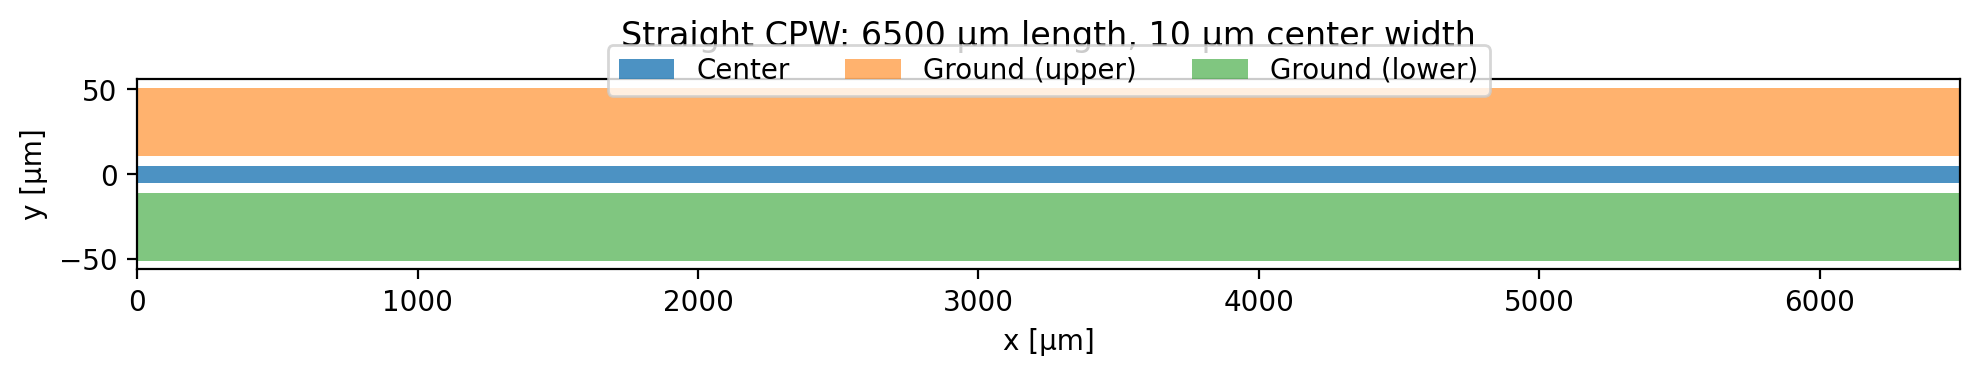

In [15]:
# @title CPW geometry parameters, GDS writer, and 2-D preview
from dataclasses import dataclass

@dataclass
class CPWParams:
    """Parametric CPW layout parameters in micrometers."""
    length_um: float = 6500.0      # total length
    center_width_um: float = 10.0  # center strip width
    gap_um: float = 6.0            # gap between center and each ground
    ground_width_um: float = 40.0  # ground plane width on each side
    layer: int = 1                 # single GDS layer for all metal


def build_cpw_cell(params: CPWParams) -> gdstk.Cell:
    """Create a gdstk cell for a straight CPW along +x."""
    cell = gdstk.Cell("CPW_6500UM_10UM")

    L = params.length_um
    wc = params.center_width_um
    g = params.gap_um
    wg = params.ground_width_um

    center_y0 = -wc / 2.0
    center_y1 = wc / 2.0
    center = gdstk.rectangle(
        (0.0, center_y0),
        (L, center_y1),
        layer=params.layer,
    )
    cell.add(center)

    upper_gy0 = wc / 2.0 + g
    upper_gy1 = upper_gy0 + wg
    lower_gy1 = -(wc / 2.0 + g)
    lower_gy0 = lower_gy1 - wg

    upper_ground = gdstk.rectangle(
        (0.0, upper_gy0),
        (L, upper_gy1),
        layer=params.layer,
    )
    lower_ground = gdstk.rectangle(
        (0.0, lower_gy0),
        (L, lower_gy1),
        layer=params.layer,
    )

    cell.add(upper_ground)
    cell.add(lower_ground)
    return cell


def write_cpw_gds(params: CPWParams, filename: str = "cpw_6500um_10um.gds") -> None:
    """Write a GDS file for the CPW geometry (units in µm)."""
    lib = gdstk.Library(
        name="CPW_LIB",
        unit=1e-6,       # 1 user unit = 1 µm
        precision=1e-9,  # database unit = 1 nm
    )
    cell = build_cpw_cell(params)
    lib.add(cell)
    lib.write_gds(filename)
    print(f"Wrote GDS file: {filename}")


def plot_cpw_layout(params: CPWParams) -> None:
    """Plan-view plot of the CPW geometry (not to scale in thickness)."""
    L = params.length_um
    wc = params.center_width_um
    g = params.gap_um
    wg = params.ground_width_um

    center_y0 = -wc / 2.0
    center_y1 = wc / 2.0
    upper_gy0 = wc / 2.0 + g
    upper_gy1 = upper_gy0 + wg
    lower_gy1 = -(wc / 2.0 + g)
    lower_gy0 = lower_gy1 - wg

    fig, ax = plt.subplots(figsize=(10, 2.0))

    ax.fill([0, L, L, 0], [center_y0, center_y0, center_y1, center_y1],
            alpha=0.8, label="Center")
    ax.fill([0, L, L, 0], [upper_gy0, upper_gy0, upper_gy1, upper_gy1],
            alpha=0.6, label="Ground (upper)")
    ax.fill([0, L, L, 0], [lower_gy0, lower_gy0, lower_gy1, lower_gy1],
            alpha=0.6, label="Ground (lower)")

    ax.set_xlabel("x [µm]")
    ax.set_ylabel("y [µm]")
    ax.set_title(f"Straight CPW: {L:.0f} µm length, {wc:.0f} µm center width", pad=12)

    ymin = lower_gy0 - 0.05 * (upper_gy1 - lower_gy0)
    ymax = upper_gy1 + 0.05 * (upper_gy1 - lower_gy0)
    ax.set_xlim(0, L)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect("auto")

    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3, frameon=True)
    fig.tight_layout()
    plt.show()


cpw_params = CPWParams()
write_cpw_gds(cpw_params)
plot_cpw_layout(cpw_params)

2-D Laplace unknowns: 22344
Solving Laplace equation on GPU with CuPy...
Cross-section potential solve complete.


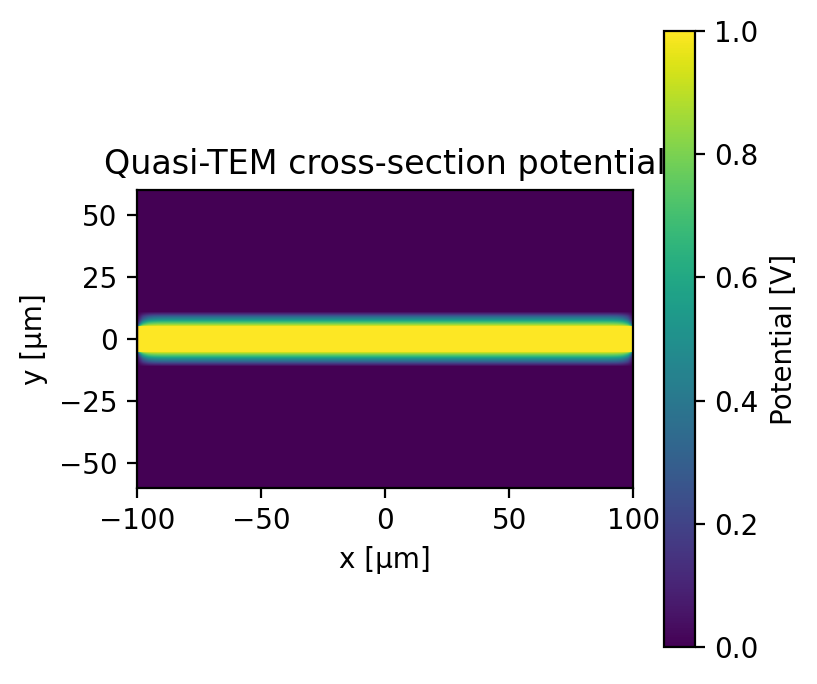

In [16]:
# @title Cross-section Laplace solve for quasi-TEM mode (GPU if available)
from typing import Dict, Tuple
from math import sqrt

if GPU_AVAILABLE and CUPY_AVAILABLE:
    import cupyx.scipy.sparse as cpx_sparse
    import cupyx.scipy.sparse.linalg as cpx_linalg
else:
    from scipy import sparse as sp_sparse
    from scipy.sparse.linalg import cg as sp_cg


@dataclass
class CrossSectionParams:
    """Simulation window and material parameters for CPW cross-section."""
    x_span_um: float = 200.0   # lateral width of simulated window
    y_span_um: float = 120.0   # height of simulated window
    nx: int = 401              # grid points in x
    ny: int = 241              # grid points in y
    eps_r: float = 11.45       # bulk permittivity (e.g. Si)
    v_center: float = 1.0      # center strip potential
    v_ground: float = 0.0      # ground potential


def build_geometry_masks(
    cpw: CPWParams,
    cs: CrossSectionParams,
) -> Dict[str, np.ndarray]:
    """Build masks for center, grounds, and outer boundary on a 2-D grid."""
    x = np.linspace(-cs.x_span_um / 2.0, cs.x_span_um / 2.0, cs.nx)
    y = np.linspace(-cs.y_span_um / 2.0, cs.y_span_um / 2.0, cs.ny)
    X, Y = np.meshgrid(x, y, indexing="xy")

    wc = cpw.center_width_um
    g = cpw.gap_um
    wg = cpw.ground_width_um

    center_mask = (np.abs(Y) <= wc / 2.0)

    upper_gy0 = wc / 2.0 + g
    upper_gy1 = upper_gy0 + wg
    lower_gy1 = -(wc / 2.0 + g)
    lower_gy0 = lower_gy1 - wg

    ground_mask = (
        ((Y >= upper_gy0) & (Y <= upper_gy1)) |
        ((Y >= lower_gy0) & (Y <= lower_gy1))
    )

    boundary_mask = np.zeros_like(center_mask, dtype=bool)
    boundary_mask[0, :] = True
    boundary_mask[-1, :] = True
    boundary_mask[:, 0] = True
    boundary_mask[:, -1] = True

    return {
        "x": x,
        "y": y,
        "center_mask": center_mask,
        "ground_mask": ground_mask,
        "boundary_mask": boundary_mask,
    }


def assemble_laplacian(
    cs: CrossSectionParams,
    masks: Dict[str, np.ndarray],
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, Dict[Tuple[int, int], int]]:
    """Assemble 5-point Laplacian matrix in COO pieces + RHS for interior nodes."""
    ny, nx = masks["center_mask"].shape
    dx = (cs.x_span_um * 1e-6) / (nx - 1)
    dy = (cs.y_span_um * 1e-6) / (ny - 1)
    dx2 = dx * dx
    dy2 = dy * dy

    center = masks["center_mask"]
    ground = masks["ground_mask"]
    boundary = masks["boundary_mask"]
    dirichlet = center | ground | boundary

    index_map: Dict[Tuple[int, int], int] = {}
    counter = 0
    for j in range(ny):
        for i in range(nx):
            if not dirichlet[j, i]:
                index_map[(j, i)] = counter
                counter += 1
    n_unknowns = counter
    print(f"2-D Laplace unknowns: {n_unknowns}")

    data: list[float] = []
    row: list[int] = []
    col: list[int] = []
    b = np.zeros(n_unknowns, dtype=np.float64)

    def is_inside(j_idx: int, i_idx: int) -> bool:
        return 0 <= j_idx < ny and 0 <= i_idx < nx

    def dirichlet_value(j_idx: int, i_idx: int) -> float:
        if center[j_idx, i_idx]:
            return cs.v_center
        if ground[j_idx, i_idx] or boundary[j_idx, i_idx]:
            return cs.v_ground
        return 0.0

    neighbors = [
        (0, -1, dx2),  # left
        (0, 1, dx2),   # right
        (-1, 0, dy2),  # down
        (1, 0, dy2),   # up
    ]

    for (j, i), k in index_map.items():
        diag = 0.0
        for dj, di, scale in neighbors:
            jj = j + dj
            ii = i + di
            if not is_inside(jj, ii):
                continue
            if (jj, ii) in index_map:
                neighbor_idx = index_map[(jj, ii)]
                data.append(1.0 / scale)
                row.append(k)
                col.append(neighbor_idx)
            else:
                v_d = dirichlet_value(jj, ii)
                b[k] -= v_d / scale
            diag -= 1.0 / scale

        data.append(diag)
        row.append(k)
        col.append(k)

    return np.array(data), np.array(row), np.array(col), b, index_map


def solve_laplace(
    cs: CrossSectionParams,
    masks: Dict[str, np.ndarray],
) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    """Solve Laplace equation either on GPU (CuPy) or CPU (SciPy)."""
    data, row, col, b, index_map = assemble_laplacian(cs, masks)
    n_unknowns = b.size

    if GPU_AVAILABLE and CUPY_AVAILABLE:
        print("Solving Laplace equation on GPU with CuPy...")
        A_csr = cpx_sparse.csr_matrix(
            (cp.asarray(data), (cp.asarray(row), cp.asarray(col))),
            shape=(n_unknowns, n_unknowns),
        )
        b_gpu = cp.asarray(b)
        phi_gpu, info = cpx_linalg.cg(A_csr, b_gpu, tol=1e-8, maxiter=20000)
        if info != 0:
            print(f"Warning: CG did not fully converge (info = {info}).")
        phi_vec = cp.asnumpy(phi_gpu)
    else:
        print("Solving Laplace equation on CPU with SciPy...")
        A_csr = sp_sparse.csr_matrix((data, (row, col)), shape=(n_unknowns, n_unknowns))
        phi_vec, info = sp_cg(A_csr, b, tol=1e-8, maxiter=20000)
        if info != 0:
            print(f"Warning: CG did not fully converge (info = {info}).")

    ny, nx = masks["center_mask"].shape
    phi = np.zeros((ny, nx), dtype=np.float64)

    phi[masks["center_mask"]] = cs.v_center
    phi[masks["ground_mask"]] = cs.v_ground
    phi[masks["boundary_mask"]] = cs.v_ground

    for (j, i), idx in index_map.items():
        phi[j, i] = phi_vec[idx]

    return phi, masks


cs_params = CrossSectionParams()
geom_masks = build_geometry_masks(cpw_params, cs_params)
phi, geom_masks = solve_laplace(cs_params, geom_masks)

print("Cross-section potential solve complete.")

plt.figure(figsize=(4, 4))
plt.imshow(phi, origin="lower",
           extent=[geom_masks["x"][0], geom_masks["x"][-1],
                   geom_masks["y"][0], geom_masks["y"][-1]])
plt.colorbar(label="Potential [V]")
plt.xlabel("x [µm]")
plt.ylabel("y [µm]")
plt.title("Quasi-TEM cross-section potential")
plt.show()

In [17]:
# @title Capacitance per length, effective permittivity, Z0, and eigenfrequencies
eps0 = 8.8541878128e-12
mu0 = 4e-7 * np.pi

def estimate_charge_per_length(
    cs: CrossSectionParams,
    masks: Dict[str, np.ndarray],
    phi: np.ndarray,
) -> float:
    """Estimate Q' on center conductor by integrating normal D on top/bottom edges."""
    center = masks["center_mask"]
    ny, nx = center.shape

    dx = (cs.x_span_um * 1e-6) / (nx - 1)
    dy = (cs.y_span_um * 1e-6) / (ny - 1)

    q_total = 0.0

    for j in range(ny):
        for i in range(nx):
            if not center[j, i]:
                continue

            if j + 1 < ny and not center[j + 1, i]:
                dphi_dy = (phi[j + 1, i] - phi[j, i]) / dy
                Dn = -cs.eps_r * eps0 * dphi_dy
                q_total += Dn * dx

            if j - 1 >= 0 and not center[j - 1, i]:
                dphi_dy = (phi[j - 1, i] - phi[j, i]) / dy
                Dn = cs.eps_r * eps0 * dphi_dy
                q_total += Dn * dx

    return q_total


Q_prime = estimate_charge_per_length(cs_params, geom_masks, phi)
C_prime = Q_prime / (cs_params.v_center - cs_params.v_ground)

eps_eff = cs_params.eps_r  # uniform model; refine later with air+substrate
vp = 3e8 / sqrt(eps_eff)
L_m = cpw_params.length_um * 1e-6

f_quarter = vp / (4.0 * L_m)
f_half = vp / (2.0 * L_m)

Z0 = 1.0 / (C_prime * vp)

print(f"C' ≈ {C_prime:.3e} F/m")
print(f"ε_eff ≈ {eps_eff:.3f}")
print(f"v_p ≈ {vp:.3e} m/s")
print(f"Z0 ≈ {Z0:.2f} Ω")
print(f"Fundamental λ/4: f ≈ {f_quarter/1e9:.3f} GHz")
print(f"Fundamental λ/2: f ≈ {f_half/1e9:.3f} GHz")

C' ≈ -4.685e-24 F/m
ε_eff ≈ 11.450
v_p ≈ 8.866e+07 m/s
Z0 ≈ -2407426877244823.00 Ω
Fundamental λ/4: f ≈ 3.410 GHz
Fundamental λ/2: f ≈ 6.820 GHz


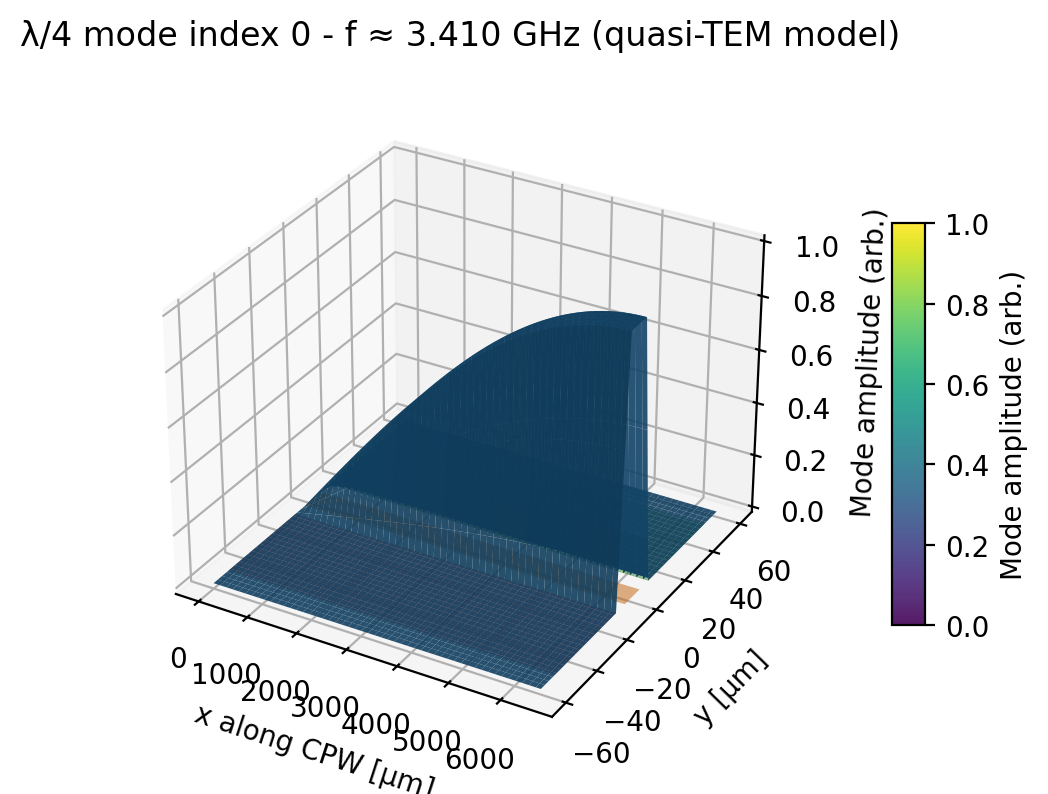

In [26]:
# @title 3-D eigenmode surface plot over CPW geometry

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


def standing_wave(
    x_um: np.ndarray,
    L_um: float,
    mode_index: int = 0,
    kind: str = "lambda_over_2",
) -> np.ndarray:
    """Standing-wave envelope along the CPW."""
    x = x_um
    if kind == "lambda_over_2":
        n = mode_index + 1
        return np.sin(n * np.pi * x / L_um)
    if kind == "lambda_over_4":
        n = mode_index
        return np.sin((2 * n + 1) * np.pi * x / (2.0 * L_um))
    raise ValueError("Unknown kind; use 'lambda_over_2' or 'lambda_over_4'.")


def add_cpw_base_3d(ax, params: CPWParams, z0: float = 0.0) -> None:
    """Draw CPW metal rectangles as surfaces at z = z0."""
    L = params.length_um
    wc = params.center_width_um
    g = params.gap_um
    wg = params.ground_width_um

    center_y0 = -wc / 2.0
    center_y1 = wc / 2.0
    upper_gy0 = wc / 2.0 + g
    upper_gy1 = upper_gy0 + wg
    lower_gy1 = -(wc / 2.0 + g)
    lower_gy0 = lower_gy1 - wg

    def patch(x0, x1, y0, y1):
        X = np.array([[x0, x1], [x0, x1]])
        Y = np.array([[y0, y0], [y1, y1]])
        Z = np.full_like(X, z0)
        ax.plot_surface(X, Y, Z, alpha=0.5)

    patch(0.0, L, center_y0, center_y1)
    patch(0.0, L, upper_gy0, upper_gy1)
    patch(0.0, L, lower_gy0, lower_gy1)


def plot_mode_surface(
    cpw: CPWParams,
    cs: CrossSectionParams,
    masks: Dict[str, np.ndarray],
    phi_field: np.ndarray,
    mode_index: int = 0,
    kind: str = "lambda_over_2",
) -> None:
    """Plot a 3-D eigenmode surface over the CPW base geometry."""
    y_vals = masks["y"]          # length ny
    ny = y_vals.size

    # Take a vertical slice of phi through the middle of the cross-section
    nx_cross = phi_field.shape[1]
    mid_idx = nx_cross // 2
    phi_line = phi_field[:, mid_idx]  # shape (ny,)

    # Normalize cross-section profile
    phi_norm = phi_line / np.max(np.abs(phi_line))
    phi_norm = np.where(np.isnan(phi_norm), 0.0, phi_norm)

    # Longitudinal grid
    n_z = 200
    x_vals = np.linspace(0.0, cpw.length_um, n_z)

    # IMPORTANT: use indexing="ij" so shapes are (n_z, ny)
    X_grid, Y_grid = np.meshgrid(x_vals, y_vals, indexing="ij")  # both (n_z, ny)

    # Standing-wave envelope along x (length n_z)
    envelope = standing_wave(x_vals, cpw.length_um,
                             mode_index=mode_index, kind=kind)  # (n_z,)

    # Broadcast to 2D: (n_z, 1) * (1, ny) -> (n_z, ny)
    envelope_grid = envelope[:, np.newaxis]
    Phi_grid = phi_norm[np.newaxis, :]
    field = envelope_grid * Phi_grid  # (n_z, ny)

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111, projection="3d")

    # Now X_grid, Y_grid, field all have shape (n_z, ny)
    surf = ax.plot_surface(
        X_grid,
        Y_grid,
        field,
        linewidth=0,
        antialiased=True,
        alpha=0.9,
    )

    # Draw CPW metal at a slightly offset z
    add_cpw_base_3d(ax, cpw, z0=field.min() * 0.1)

    ax.set_xlabel("x along CPW [µm]")
    ax.set_ylabel("y [µm]")
    ax.set_zlabel("Mode amplitude (arb.)")

    if kind == "lambda_over_2":
        f0 = (mode_index + 1) * f_half
        title_kind = "λ/2"
    else:
        f0 = (2 * mode_index + 1) * f_quarter
        title_kind = "λ/4"

    ax.set_title(
        f"{title_kind} mode index {mode_index} - "
        f"f ≈ {f0/1e9:.3f} GHz (quasi-TEM model)",
        pad=16,
    )

    fig.colorbar(surf, shrink=0.6, aspect=12, label="Mode amplitude (arb.)")
    ax.view_init(elev=30, azim=-60)
    plt.tight_layout()
    plt.show()


# Example: fundamental λ/2 mode
# plot_mode_surface(cpw_params, cs_params, geom_masks, phi,
#                   mode_index=0, kind="lambda_over_2")

# Example: fundamental λ/4 mode
plot_mode_surface(cpw_params, cs_params, geom_masks, phi,
                  mode_index=0, kind="lambda_over_4")

In [25]:
# @title Write a Palace eigenmode config template (for offline use)
import json

palace_config = {
    "Problem": {
        "Type": "Eigenmode",
        "Output": "cpw_modes",
        "Verbose": 1,
    },
    "Model": {
        "Order": 2,
    },
    "Mesh": {
        "Filename": "cpw_3d_cpw.msh"  # replace with your Gmsh/MFEM mesh path
    },
    "Domains": {
        "Material": [
            {
                "Attributes": [1],  # substrate volume id(s)
                "Permittivity": {"Re": cs_params.eps_r, "Im": 0.0},
            },
            {
                "Attributes": [2],  # air volume id(s)
                "Permittivity": {"Re": 1.0, "Im": 0.0},
            },
        ]
    },
    "Boundaries": {
        "PerfectConductor": [
            {"Attributes": [101, 201, 202]}  # center and grounds surface ids
        ]
    },
    "Solver": {
        "Device": "GPU",   # Palace will select CUDA backend for NVIDIA by default
        "Eigenmode": {
            "Target": float(f_half / 1e9),  # GHz range of interest
            "Tol": 1.0e-6,
            "N": 4,
            "Save": 4,
        },
    },
}

with open("cpw_eigenmode_palace.json", "w", encoding="utf-8") as f:
    json.dump(palace_config, f, indent=2)

print("Wrote Palace config file: cpw_eigenmode_palace.json")
print("Pair this with cpw_3d_cpw.msh and run:")
print("  palace cpw_eigenmode_palace.json")

Wrote Palace config file: cpw_eigenmode_palace.json
Pair this with cpw_3d_cpw.msh and run:
  palace cpw_eigenmode_palace.json


| Acronym | Expansion                                   | Comment                                                        |
|---------|---------------------------------------------|----------------------------------------------------------------|
| CPW     | Coplanar Waveguide                          | Planar line with center strip and ground planes on same side  |
| GDS     | Graphic Design System                       | IC layout format (GDSII = version 2)                          |
| FEM     | Finite Element Method                       | Variational PDE discretization method                         |
| FDTD    | Finite-Difference Time-Domain               | Time-stepping Maxwell solver                                  |
| GPU     | Graphics Processing Unit                    | Parallel numeric accelerator (here NVIDIA L4)                 |
| CuPy    | CUDA Python Array Library                   | NumPy-like arrays backed by CUDA                              |
| MFEM    | Modular Finite Element Methods              | High-order FEM library used inside Palace                     |
| libCEED | Library for Efficient Extensible Discretizations | High-performance operator backend (used by Palace)      |
| Palace  | Parallel Large-scale Computational EM       | AWS open-source 3-D FEM EM solver                            |
| εr      | Relative permittivity                       | ε / ε0                                                        |
| εeff    | Effective permittivity                      | Mode’s effective ε in waveguide / CPW                         |
| C′      | Capacitance per unit length                 | C per meter of CPW                                            |
| Z0      | Characteristic impedance                    | √(L′/C′) for a transmission line                              |
| λ/2     | Half-wavelength resonator mode              | Node–node or antinode–antinode, depending on boundary        |
| λ/4     | Quarter-wavelength resonator mode           | Short–open or open–short resonator configuration             |
